# Analysis of memory-pool simulations

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(ggraph, quietly=TRUE)
    require(igraph, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(tidygraph, quietly=TRUE)
})

## Adversarial nodes

### Read data

In [2]:
adversaries <- fread("adversaries.tsv.gz", stringsAsFactors=TRUE)[`Adversarial nodes` != 310]
adversaries %>% summary

 Adversarial nodes    Block ID         Txs          Honest txs   
 Min.   :  0.0     B0     : 100   Min.   : 0.00   Min.   : 0.00  
 1st Qu.:120.0     B1     : 100   1st Qu.:60.00   1st Qu.:54.00  
 Median :245.0     B10    : 100   Median :60.00   Median :59.00  
 Mean   :248.6     B11    : 100   Mean   :52.24   Mean   :50.89  
 3rd Qu.:375.0     B12    : 100   3rd Qu.:60.00   3rd Qu.:60.00  
 Max.   :500.0     B13    : 100   Max.   :60.00   Max.   :60.00  
                   (Other):6044                                  
 Adversarial txs
 Min.   : 0.00  
 1st Qu.: 0.00  
 Median : 1.00  
 Mean   : 1.35  
 3rd Qu.: 2.00  
 Max.   :35.00  
                

### Raw data at the block level

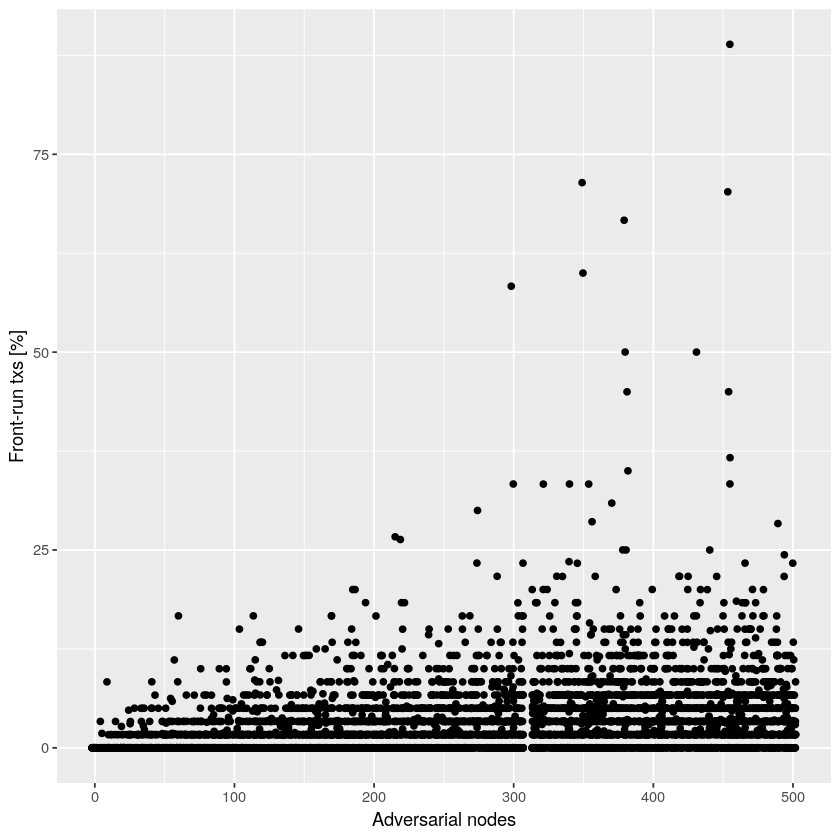

In [3]:
ggplot(
    adversaries[
        `Txs` > 0,
        .(`Front-run txs [%]`=100*sum(`Adversarial txs`)/sum(`Txs`)),
        .(`Adversarial nodes`, `Block ID`)
    ], 
    aes(x=`Adversarial nodes`, y=`Front-run txs [%]`)
) +
    geom_jitter()

### Trends

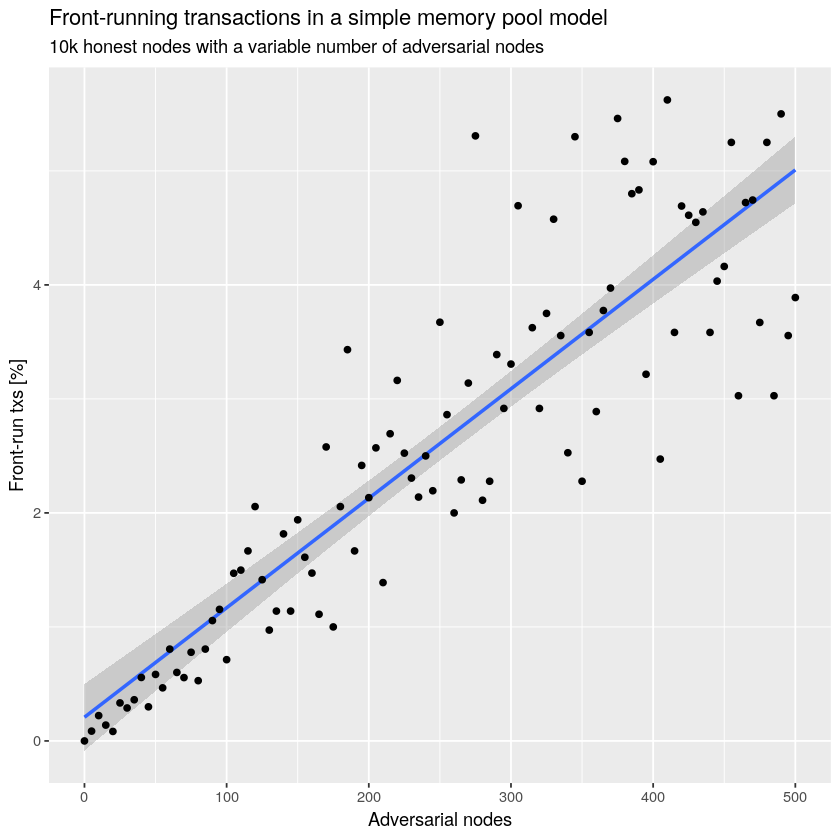

In [4]:
ggplot(
    adversaries[
        ,
        .(`Front-run txs [%]`=100*sum(`Adversarial txs`)/sum(`Txs`)),
        .(`Adversarial nodes`)
    ], 
    aes(x=`Adversarial nodes`, y=`Front-run txs [%]`)
) +
    geom_smooth(formula=y~x, method="lm") +
    geom_point() +
    ggtitle(
        "Front-running transactions in a simple memory pool model",
        "10k honest nodes with a variable number of adversarial nodes"
    )

In [5]:
ggsave("mempool-scatter.png", units="in", dpi=150, width=8, height=6)

In [6]:
ggsave("mempool-scatter.svg", units="in", dpi=150, width=8, height=6)